In [1]:
### Configs ###
TASK = "multi_tasks"  # choose from 'pose_single', 'pose_multi', 'depth', 'multi_tasks'
MODEL = "vgg19_bn"  # enter model name
N_EPOCHS = 128  # enter number of epochs
EARLY_STOPPING_PATIENCE = (
    16  # Stop if validation loss doesn't improve for this many epochs
)
LEARNING_RATE = 1e-4  # enter learning rate
AUGMENTATION = True
CONTINUE_TRAINING = False
MULTI_TASKS_POSE_TYPE = "single"  # "single" or "multi"
MULTI_TASKS_REGRESSION_LOSS_WEIGHT = 8  # Weight for regression loss in multi-tasks
COLAB_DATA_MODE = "mount"  # Can be 'mount' (symlink) or 'copy'. Only used if on colab

In [2]:
### Setup if using colab ###
import os
import sys
import subprocess
import shutil  # Added import for shutil


def in_colab() -> bool:
    try:
        import google.colab  # type: ignore

        return True
    except Exception:
        return False


if in_colab():
    from google.colab import drive  # type: ignore

    print("Detected Colab. Mounting Drive...")
    drive.mount("/content/drive", force_remount=False)

    GITHUB_REPO = "https://github.com/chihuangliu/microrobot-dl.git"
    REPO_PATH = "/content/microrobot-dl"
    DRIVE_DATA_PATH = "/content/drive/MyDrive/microrobot-dl-data/data"  # where you uploaded your data on Drive

    # Clone repo if missing
    if not os.path.exists(REPO_PATH):
        print("Cloning repository...")
        subprocess.check_call(["git", "clone", GITHUB_REPO, REPO_PATH])
    else:
        print("Repository already cloned:", REPO_PATH)

    # Install package (editable) from repo root
    os.chdir(REPO_PATH)
    print("Installing package from", REPO_PATH)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "uv"])
    subprocess.check_call([sys.executable, "-m", "uv", "pip", "install", "-e", "."])

    # Handle data based on COLAB_DATA_MODE
    repo_data_path = os.path.join(REPO_PATH, "data")

    # Clean up existing data path entry point first
    if os.path.exists(repo_data_path):
        if os.path.islink(repo_data_path):
            print(f"Removing existing symlink: {repo_data_path}")
            os.unlink(repo_data_path)
        elif os.path.isdir(repo_data_path):
            print(f"Removing existing directory: {repo_data_path}")
            shutil.rmtree(repo_data_path)
        else:
            print(f"Removing existing file/socket: {repo_data_path}")
            os.remove(repo_data_path)

    if not os.path.exists(DRIVE_DATA_PATH):
        print("Drive data path not found:", DRIVE_DATA_PATH)
        print(
            "Upload your data to Drive and set DRIVE_DATA_PATH accordingly. No data will be linked/copied."
        )
    else:
        if COLAB_DATA_MODE == "copy":
            print("Copying Drive data from:", DRIVE_DATA_PATH, "to", repo_data_path)
            shutil.copytree(DRIVE_DATA_PATH, repo_data_path)
            print("Data copied successfully.")
        elif COLAB_DATA_MODE == "mount":
            print(
                "Creating symlink from Drive data:",
                DRIVE_DATA_PATH,
                "to",
                repo_data_path,
            )
            os.symlink(DRIVE_DATA_PATH, repo_data_path)
            print("Data symlinked successfully.")
        else:
            print(
                f"Warning: Unknown COLAB_DATA_MODE '{COLAB_DATA_MODE}'. No data will be linked/copied."
            )

    # Change into notebooks/ so relative paths in the notebook continue to work
    notebooks_dir = os.path.join(REPO_PATH, "notebooks")
    if os.path.isdir(notebooks_dir):
        os.chdir(notebooks_dir)
        print("Changed working dir to notebooks:", os.getcwd())
    else:
        print("No notebooks/ dir found; current working dir:", os.getcwd())

    if REPO_PATH not in sys.path:
        sys.path.insert(0, REPO_PATH)
else:
    print("Not running on colab.")

Not running on colab.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from microrobot_dl.data_loader import ImageDataset2025
from microrobot_dl.testset import get_imagedataset2025_test_set
from microrobot_dl.data_loader import get_dataloaders
from microrobot_dl.model import get_model
from microrobot_dl.transform import AddGaussianNoise, TranslateTransform, ZoomTransform
from microrobot_dl.task import Task
from microrobot_dl.inference import evaluate_model, run_inference
from tqdm import tqdm
import os
import json


torch.manual_seed(60648)

# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif (
    getattr(torch.backends, "mps", None) is not None
    and torch.backends.mps.is_available()
    and torch.backends.mps.is_built()
):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [4]:
# Load Dataset
num_outputs = 1
mode = None
multi_label = False

if TASK == Task.pose_single:
    mode = "pose"
    multi_label = False
elif TASK == Task.pose_multi:
    mode = "pose"
    multi_label = True
elif TASK == Task.depth:
    mode = "depth"
elif TASK == Task.multi_tasks:
    mode = None
    multi_label = MULTI_TASKS_POSE_TYPE == "multi"
else:
    raise ValueError(f"Task {TASK} not supported yet.")

dataset = ImageDataset2025(
    base_dir="../data/2025_Dataset",
    mode=mode,
    multi_label=multi_label,
    multi_task=(TASK == Task.multi_tasks),
    transform=None,
)

if TASK == Task.pose_multi or (TASK == Task.multi_tasks and multi_label):
    num_classes_p = len(dataset.idx_to_label_p)
    num_classes_r = len(dataset.idx_to_label_r)
    num_outputs = num_classes_p + num_classes_r
    print(f"Pose Multi: P classes={num_classes_p}, R classes={num_classes_r}")
elif TASK == Task.pose_single or (TASK == Task.multi_tasks and not multi_label):
    num_outputs = len(dataset.idx_to_label)

if TASK == Task.multi_tasks:
    num_outputs += 1  # Add depth output
    print(f"Multi Task: Pose outputs + 1 Depth output = {num_outputs}")

print(f"mode: {mode}, num_outputs: {num_outputs}")
print(f"Total samples: {len(dataset)}")

Multi Task: Pose outputs + 1 Depth output = 41
mode: None, num_outputs: 41
Total samples: 2000


In [5]:
test_set_info = get_imagedataset2025_test_set()
test_indices = test_set_info["test_indices"]
test_indices = list(test_indices)
test_set = set(test_indices)

test_len = len(test_indices)
train_val_len = len(dataset) - test_len

all_indices = list(range(len(dataset)))
train_val_indices = [i for i in all_indices if i not in test_set]

test_dataset = torch.utils.data.Subset(dataset, test_indices)
train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)

transform_test = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

if AUGMENTATION:
    if TASK in [Task.pose_single, Task.pose_multi]:
        transform_train = transforms.Compose(
            [
                transforms.Resize((240, 240)),
                TranslateTransform(),
                ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.02),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )
    elif TASK == Task.depth:
        transform_train = transforms.Compose(
            [
                transforms.Resize((240, 240)),
                TranslateTransform(),
                ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
                transforms.RandomRotation(degrees=15.0),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.01),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )
    elif TASK == Task.multi_tasks:
        transform_train = transforms.Compose(
            [
                transforms.Resize((240, 240)),
                TranslateTransform(),
                ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.01),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )

else:
    transform_train = transform_test


t_train = transform_train if AUGMENTATION else transform_test
t_test = transform_test

train_loader, test_loader, val_loader = get_dataloaders(
    train_val_dataset,
    test_dataset,
    val_ratio=0.1,
    train_batch_size=32,
    test_batch_size=64,
    val_batch_size=64,
    transform_train=t_train,
    transform_test=t_test,
)

In [6]:
# Setup Model
model = get_model(MODEL, num_outputs=num_outputs, in_channels=1)

if model is None:
    raise ValueError(f"Model {MODEL} not supported.")

model = model.to(device)

# Loss and Optimizer
if TASK in [Task.pose_single, Task.pose_multi]:
    criterion = nn.CrossEntropyLoss()
elif TASK == Task.depth:
    criterion = nn.MSELoss()
elif TASK == Task.multi_tasks:
    criterion_pose = nn.CrossEntropyLoss()
    criterion_depth = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
suffix = ""
if AUGMENTATION:
    suffix += "_augmented"

if multi_label and TASK == Task.multi_tasks:
    suffix += "_multi_label"

MODEL_NAME = f"{MODEL}_{TASK}{suffix}"
MODEL_PATH = f"../model/{MODEL_NAME}.pth"
train_losses, val_losses = [], []
train_accs, val_accs = [], []  # Stores Accuracy for pose, RMSE for depth
best_val_loss = float("inf")
epochs_no_improve = 0  # Counter for early stopping


if CONTINUE_TRAINING and os.path.exists(MODEL_PATH):
    print(f"Loading checkpoint from {MODEL_PATH}...")
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    if "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    best_val_loss = checkpoint.get("val_loss", float("inf"))
    start_epoch = checkpoint.get("epoch", 0)

for epoch in range(N_EPOCHS):
    running_loss = 0.0
    running_mse = 0.0
    correct = 0
    total = 0

    for outputs, labels in tqdm(
        run_inference(model, train_loader, device, TASK, training=True),
        total=len(train_loader),
    ):
        optimizer.zero_grad()

        if TASK == Task.multi_tasks:
            pose_labels, depth_labels = labels
        else:
            # labels is already a tensor on device
            pass

        if TASK == Task.pose_multi:
            # labels: [batch, 2] (p, r)
            label_p = labels[:, 0]
            label_r = labels[:, 1]

            # Split output
            out_p = outputs[:, :num_classes_p]
            out_r = outputs[:, num_classes_p:]

            loss = criterion(out_p, label_p) + criterion(out_r, label_r)
        elif TASK == Task.multi_tasks:
            if multi_label:
                # outputs: [batch, num_p + num_r + 1]
                out_p = outputs[:, :num_classes_p]
                out_r = outputs[:, num_classes_p : num_classes_p + num_classes_r]
                out_d = outputs[:, -1:]

                label_p = pose_labels[:, 0]
                label_r = pose_labels[:, 1]

                loss_depth = criterion_depth(out_d, depth_labels)
                loss = (
                    criterion_pose(out_p, label_p)
                    + criterion_pose(out_r, label_r)
                    + loss_depth * MULTI_TASKS_REGRESSION_LOSS_WEIGHT
                )
            else:
                # outputs: [batch, num_classes + 1]
                out_pose = outputs[:, :-1]
                out_d = outputs[:, -1:]

                loss_depth = criterion_depth(out_d, depth_labels)
                loss = (
                    criterion_pose(out_pose, pose_labels)
                    + loss_depth * MULTI_TASKS_REGRESSION_LOSS_WEIGHT
                )

            running_mse += loss_depth.item() * outputs.size(0)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * outputs.size(0)

        if TASK == Task.pose_single:
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        elif TASK == Task.pose_multi:
            out_p = outputs[:, :num_classes_p]
            out_r = outputs[:, num_classes_p:]
            _, pred_p = torch.max(out_p, 1)
            _, pred_r = torch.max(out_r, 1)
            total += labels.size(0)
            # Joint accuracy: both must be correct
            correct += (
                ((pred_p == labels[:, 0]) & (pred_r == labels[:, 1])).sum().item()
            )
        elif TASK == Task.multi_tasks:
            if multi_label:
                out_p = outputs[:, :num_classes_p]
                out_r = outputs[:, num_classes_p : num_classes_p + num_classes_r]
                _, pred_p = torch.max(out_p, 1)
                _, pred_r = torch.max(out_r, 1)
                total += pose_labels.size(0)
                correct += (
                    ((pred_p == pose_labels[:, 0]) & (pred_r == pose_labels[:, 1]))
                    .sum()
                    .item()
                )
            else:
                out_pose = outputs[:, :-1]
                _, pred = torch.max(out_pose, 1)
                total += pose_labels.size(0)
                correct += (pred == pose_labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_rmse = 0.0

    if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks]:
        epoch_metric = correct / total
    else:
        epoch_metric = epoch_loss**0.5  # RMSE

    if TASK == Task.multi_tasks:
        epoch_rmse = (running_mse / total) ** 0.5

    train_losses.append(epoch_loss)
    train_accs.append(epoch_metric)

    # Validation phase
    val_results = evaluate_model(
        model,
        val_loader,
        device,
        TASK,
        criterion=criterion if TASK not in [Task.multi_tasks] else None,
        criterion_pose=criterion_pose if TASK == Task.multi_tasks else None,
        criterion_depth=criterion_depth if TASK == Task.multi_tasks else None,
        num_classes_p=num_classes_p if "num_classes_p" in locals() else 0,
        num_classes_r=num_classes_r if "num_classes_r" in locals() else 0,
        multi_label=multi_label,
        multi_tasks_regression_loss_weight=MULTI_TASKS_REGRESSION_LOSS_WEIGHT,
    )

    val_loss = val_results["loss"]
    val_metric = val_results.get("accuracy", val_results.get("rmse", 0.0))
    val_rmse = val_results.get("rmse", 0.0)

    val_losses.append(val_loss)
    val_accs.append(val_metric)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # Reset counter
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_metric": val_metric,
                "val_loss": val_loss,
            },
            MODEL_PATH,
        )
        print(f"Saved best model to {MODEL_PATH} (Val Loss: {val_loss:.4f})")
    else:
        epochs_no_improve += 1

    if TASK == Task.multi_tasks:
        print(
            f"Epoch {epoch + 1}/{N_EPOCHS} - Train Loss: {epoch_loss:.4f} Acc: {epoch_metric:.4f} RMSE: {epoch_rmse:.4f} | Val Loss: {val_loss:.4f} Acc: {val_metric:.4f} RMSE: {val_rmse:.4f}"
        )
    else:
        metric_name = "Acc" if TASK in [Task.pose_single, Task.pose_multi] else "RMSE"
        print(
            f"Epoch {epoch + 1}/{N_EPOCHS} - Train Loss: {epoch_loss:.4f} {metric_name}: {epoch_metric:.4f} | Val Loss: {val_loss:.4f} {metric_name}: {val_metric:.4f}"
        )

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(
            f"Early stopping triggered. No improvement for {EARLY_STOPPING_PATIENCE} epochs."
        )
        break

100%|██████████| 45/45 [00:42<00:00,  1.07it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 4.7334)
Epoch 1/128 - Train Loss: 45.3397 Acc: 0.0222 RMSE: 2.2770 | Val Loss: 4.7334 Acc: 0.0250 RMSE: 0.3596


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 4.0747)
Epoch 2/128 - Train Loss: 4.9765 Acc: 0.0271 RMSE: 0.3965 | Val Loss: 4.0747 Acc: 0.0375 RMSE: 0.2286


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 3.8801)
Epoch 3/128 - Train Loss: 4.4802 Acc: 0.0306 RMSE: 0.3188 | Val Loss: 3.8801 Acc: 0.0813 RMSE: 0.1782


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 3.7597)
Epoch 4/128 - Train Loss: 4.2875 Acc: 0.0451 RMSE: 0.2885 | Val Loss: 3.7597 Acc: 0.1313 RMSE: 0.1410


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 3.6974)
Epoch 5/128 - Train Loss: 4.0657 Acc: 0.0521 RMSE: 0.2423 | Val Loss: 3.6974 Acc: 0.0875 RMSE: 0.1289


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 3.6581)
Epoch 6/128 - Train Loss: 3.9763 Acc: 0.0750 RMSE: 0.2277 | Val Loss: 3.6581 Acc: 0.1187 RMSE: 0.1206


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 3.6364)
Epoch 7/128 - Train Loss: 3.9317 Acc: 0.0556 RMSE: 0.2219 | Val Loss: 3.6364 Acc: 0.1125 RMSE: 0.1267


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 3.5549)
Epoch 8/128 - Train Loss: 3.8250 Acc: 0.0847 RMSE: 0.2049 | Val Loss: 3.5549 Acc: 0.1375 RMSE: 0.1146


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 3.4741)
Epoch 9/128 - Train Loss: 3.7795 Acc: 0.0986 RMSE: 0.2051 | Val Loss: 3.4741 Acc: 0.1750 RMSE: 0.0997


100%|██████████| 45/45 [00:41<00:00,  1.10it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 3.4086)
Epoch 10/128 - Train Loss: 3.7070 Acc: 0.1000 RMSE: 0.1951 | Val Loss: 3.4086 Acc: 0.1938 RMSE: 0.1077


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 3.3238)
Epoch 11/128 - Train Loss: 3.6613 Acc: 0.1028 RMSE: 0.2003 | Val Loss: 3.3238 Acc: 0.1625 RMSE: 0.1099


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 3.1981)
Epoch 12/128 - Train Loss: 3.5538 Acc: 0.1257 RMSE: 0.1943 | Val Loss: 3.1981 Acc: 0.2000 RMSE: 0.0970


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 3.0635)
Epoch 13/128 - Train Loss: 3.4548 Acc: 0.1285 RMSE: 0.1866 | Val Loss: 3.0635 Acc: 0.2938 RMSE: 0.0967


100%|██████████| 45/45 [00:41<00:00,  1.10it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 2.9603)
Epoch 14/128 - Train Loss: 3.3711 Acc: 0.1375 RMSE: 0.1954 | Val Loss: 2.9603 Acc: 0.3000 RMSE: 0.1043


100%|██████████| 45/45 [00:41<00:00,  1.10it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 2.8260)
Epoch 15/128 - Train Loss: 3.2887 Acc: 0.1576 RMSE: 0.1978 | Val Loss: 2.8260 Acc: 0.3563 RMSE: 0.0941


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 2.7022)
Epoch 16/128 - Train Loss: 3.1929 Acc: 0.1840 RMSE: 0.1971 | Val Loss: 2.7022 Acc: 0.3438 RMSE: 0.1025


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 17/128 - Train Loss: 3.0435 Acc: 0.2160 RMSE: 0.1898 | Val Loss: 2.7116 Acc: 0.3063 RMSE: 0.1415


100%|██████████| 45/45 [00:40<00:00,  1.10it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 2.5160)
Epoch 18/128 - Train Loss: 2.9633 Acc: 0.2194 RMSE: 0.1921 | Val Loss: 2.5160 Acc: 0.3063 RMSE: 0.1159


100%|██████████| 45/45 [00:40<00:00,  1.11it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 2.4131)
Epoch 19/128 - Train Loss: 2.8806 Acc: 0.2326 RMSE: 0.1937 | Val Loss: 2.4131 Acc: 0.3187 RMSE: 0.1035


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 2.3281)
Epoch 20/128 - Train Loss: 2.7739 Acc: 0.2708 RMSE: 0.1965 | Val Loss: 2.3281 Acc: 0.3688 RMSE: 0.1301


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 2.2111)
Epoch 21/128 - Train Loss: 2.6972 Acc: 0.2944 RMSE: 0.2014 | Val Loss: 2.2111 Acc: 0.3625 RMSE: 0.0886


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 2.0951)
Epoch 22/128 - Train Loss: 2.6143 Acc: 0.2743 RMSE: 0.1960 | Val Loss: 2.0951 Acc: 0.3812 RMSE: 0.1026


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 2.0440)
Epoch 23/128 - Train Loss: 2.4955 Acc: 0.3090 RMSE: 0.2013 | Val Loss: 2.0440 Acc: 0.4000 RMSE: 0.1033


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 1.9676)
Epoch 24/128 - Train Loss: 2.4189 Acc: 0.3292 RMSE: 0.2014 | Val Loss: 1.9676 Acc: 0.4188 RMSE: 0.1157


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 1.7974)
Epoch 25/128 - Train Loss: 2.3052 Acc: 0.3403 RMSE: 0.1925 | Val Loss: 1.7974 Acc: 0.3937 RMSE: 0.0878


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 1.6730)
Epoch 26/128 - Train Loss: 2.2007 Acc: 0.3854 RMSE: 0.2040 | Val Loss: 1.6730 Acc: 0.4125 RMSE: 0.0870


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 1.6432)
Epoch 27/128 - Train Loss: 2.1267 Acc: 0.4125 RMSE: 0.1997 | Val Loss: 1.6432 Acc: 0.4750 RMSE: 0.0841


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 28/128 - Train Loss: 2.0127 Acc: 0.4229 RMSE: 0.1909 | Val Loss: 1.8050 Acc: 0.4437 RMSE: 0.1735


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 1.6184)
Epoch 29/128 - Train Loss: 1.9350 Acc: 0.4528 RMSE: 0.1946 | Val Loss: 1.6184 Acc: 0.4500 RMSE: 0.1200


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 30/128 - Train Loss: 1.8762 Acc: 0.4556 RMSE: 0.1954 | Val Loss: 1.8472 Acc: 0.4562 RMSE: 0.2200


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 31/128 - Train Loss: 1.8590 Acc: 0.4833 RMSE: 0.2090 | Val Loss: 1.8213 Acc: 0.5062 RMSE: 0.2477


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 1.4386)
Epoch 32/128 - Train Loss: 1.7505 Acc: 0.4910 RMSE: 0.1926 | Val Loss: 1.4386 Acc: 0.4688 RMSE: 0.1405


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 33/128 - Train Loss: 1.6679 Acc: 0.5236 RMSE: 0.1980 | Val Loss: 1.4868 Acc: 0.4813 RMSE: 0.1439


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 1.3003)
Epoch 34/128 - Train Loss: 1.6387 Acc: 0.5403 RMSE: 0.1948 | Val Loss: 1.3003 Acc: 0.5312 RMSE: 0.1084


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 35/128 - Train Loss: 1.5632 Acc: 0.5826 RMSE: 0.2070 | Val Loss: 1.3957 Acc: 0.5312 RMSE: 0.1658


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 1.2332)
Epoch 36/128 - Train Loss: 1.5170 Acc: 0.5625 RMSE: 0.1958 | Val Loss: 1.2332 Acc: 0.6250 RMSE: 0.1183


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 1.0105)
Epoch 37/128 - Train Loss: 1.4560 Acc: 0.6069 RMSE: 0.1962 | Val Loss: 1.0105 Acc: 0.6188 RMSE: 0.0815


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 38/128 - Train Loss: 1.3529 Acc: 0.6257 RMSE: 0.1857 | Val Loss: 1.1124 Acc: 0.6937 RMSE: 0.1604


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 39/128 - Train Loss: 1.2617 Acc: 0.6326 RMSE: 0.1775 | Val Loss: 1.2759 Acc: 0.5938 RMSE: 0.1995


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 40/128 - Train Loss: 1.2859 Acc: 0.6285 RMSE: 0.1940 | Val Loss: 1.0778 Acc: 0.6562 RMSE: 0.1363


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 41/128 - Train Loss: 1.1785 Acc: 0.6576 RMSE: 0.1826 | Val Loss: 1.1822 Acc: 0.6625 RMSE: 0.2017


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 42/128 - Train Loss: 1.1328 Acc: 0.6937 RMSE: 0.1864 | Val Loss: 1.0218 Acc: 0.6438 RMSE: 0.1149


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 43/128 - Train Loss: 1.1128 Acc: 0.7063 RMSE: 0.1874 | Val Loss: 1.3167 Acc: 0.7875 RMSE: 0.2815


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 0.9138)
Epoch 44/128 - Train Loss: 1.1341 Acc: 0.7097 RMSE: 0.2002 | Val Loss: 0.9138 Acc: 0.8000 RMSE: 0.1896


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 45/128 - Train Loss: 1.0140 Acc: 0.7271 RMSE: 0.1787 | Val Loss: 1.0517 Acc: 0.7937 RMSE: 0.2202


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 46/128 - Train Loss: 0.9881 Acc: 0.7326 RMSE: 0.1831 | Val Loss: 1.1774 Acc: 0.7625 RMSE: 0.2578


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 47/128 - Train Loss: 1.0175 Acc: 0.7361 RMSE: 0.1895 | Val Loss: 0.9565 Acc: 0.7125 RMSE: 0.1558


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 48/128 - Train Loss: 0.9338 Acc: 0.7562 RMSE: 0.1787 | Val Loss: 1.0082 Acc: 0.7875 RMSE: 0.2382


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 0.8508)
Epoch 49/128 - Train Loss: 0.8506 Acc: 0.7590 RMSE: 0.1656 | Val Loss: 0.8508 Acc: 0.7812 RMSE: 0.2125


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 50/128 - Train Loss: 0.8402 Acc: 0.7812 RMSE: 0.1784 | Val Loss: 0.8722 Acc: 0.7000 RMSE: 0.1137


100%|██████████| 45/45 [00:42<00:00,  1.06it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 0.7908)
Epoch 51/128 - Train Loss: 0.8218 Acc: 0.7778 RMSE: 0.1683 | Val Loss: 0.7908 Acc: 0.7250 RMSE: 0.0964


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 0.7156)
Epoch 52/128 - Train Loss: 0.8388 Acc: 0.7931 RMSE: 0.1822 | Val Loss: 0.7156 Acc: 0.8063 RMSE: 0.1635


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 53/128 - Train Loss: 0.8053 Acc: 0.7958 RMSE: 0.1779 | Val Loss: 0.8869 Acc: 0.8438 RMSE: 0.2382


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 54/128 - Train Loss: 0.7470 Acc: 0.8187 RMSE: 0.1716 | Val Loss: 0.7418 Acc: 0.8000 RMSE: 0.1807


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 0.6098)
Epoch 55/128 - Train Loss: 0.7538 Acc: 0.8035 RMSE: 0.1724 | Val Loss: 0.6098 Acc: 0.8313 RMSE: 0.1760


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 56/128 - Train Loss: 0.7014 Acc: 0.8243 RMSE: 0.1655 | Val Loss: 0.8540 Acc: 0.7875 RMSE: 0.2079


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 57/128 - Train Loss: 0.6417 Acc: 0.8521 RMSE: 0.1658 | Val Loss: 0.7309 Acc: 0.8875 RMSE: 0.2222


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 58/128 - Train Loss: 0.6286 Acc: 0.8674 RMSE: 0.1743 | Val Loss: 0.6219 Acc: 0.9187 RMSE: 0.2097


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 59/128 - Train Loss: 0.6344 Acc: 0.8556 RMSE: 0.1677 | Val Loss: 1.8562 Acc: 0.7000 RMSE: 0.3115


100%|██████████| 45/45 [00:42<00:00,  1.07it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 0.5994)
Epoch 60/128 - Train Loss: 0.6319 Acc: 0.8542 RMSE: 0.1664 | Val Loss: 0.5994 Acc: 0.8812 RMSE: 0.1840


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 61/128 - Train Loss: 0.5681 Acc: 0.8715 RMSE: 0.1578 | Val Loss: 0.6439 Acc: 0.8625 RMSE: 0.1941


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 62/128 - Train Loss: 0.5481 Acc: 0.8917 RMSE: 0.1679 | Val Loss: 0.7203 Acc: 0.8375 RMSE: 0.1907


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 63/128 - Train Loss: 0.5485 Acc: 0.8681 RMSE: 0.1548 | Val Loss: 0.6014 Acc: 0.8938 RMSE: 0.1981


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 0.4771)
Epoch 64/128 - Train Loss: 0.5506 Acc: 0.8729 RMSE: 0.1581 | Val Loss: 0.4771 Acc: 0.9187 RMSE: 0.1695


100%|██████████| 45/45 [00:41<00:00,  1.07it/s]



Epoch 65/128 - Train Loss: 0.4824 Acc: 0.8889 RMSE: 0.1467 | Val Loss: 0.4899 Acc: 0.9125 RMSE: 0.1794


100%|██████████| 45/45 [00:42<00:00,  1.07it/s]



Epoch 66/128 - Train Loss: 0.5784 Acc: 0.8812 RMSE: 0.1671 | Val Loss: 0.5994 Acc: 0.7875 RMSE: 0.1174


100%|██████████| 45/45 [00:41<00:00,  1.07it/s]



Epoch 67/128 - Train Loss: 0.4806 Acc: 0.9118 RMSE: 0.1548 | Val Loss: 1.1236 Acc: 0.7250 RMSE: 0.2606


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 68/128 - Train Loss: 0.4802 Acc: 0.9111 RMSE: 0.1514 | Val Loss: 0.5916 Acc: 0.8375 RMSE: 0.1266


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 69/128 - Train Loss: 0.5107 Acc: 0.8875 RMSE: 0.1559 | Val Loss: 0.6880 Acc: 0.7688 RMSE: 0.1174


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 0.3832)
Epoch 70/128 - Train Loss: 0.4587 Acc: 0.9104 RMSE: 0.1551 | Val Loss: 0.3832 Acc: 0.8562 RMSE: 0.0866


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 71/128 - Train Loss: 0.3839 Acc: 0.9299 RMSE: 0.1400 | Val Loss: 0.4413 Acc: 0.9125 RMSE: 0.1724


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 72/128 - Train Loss: 0.4436 Acc: 0.9014 RMSE: 0.1520 | Val Loss: 0.5669 Acc: 0.8875 RMSE: 0.1784


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 73/128 - Train Loss: 0.4347 Acc: 0.9243 RMSE: 0.1564 | Val Loss: 0.9820 Acc: 0.9062 RMSE: 0.3056


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 74/128 - Train Loss: 0.4024 Acc: 0.9222 RMSE: 0.1444 | Val Loss: 0.8940 Acc: 0.8375 RMSE: 0.2193


100%|██████████| 45/45 [00:41<00:00,  1.07it/s]



Epoch 75/128 - Train Loss: 0.4318 Acc: 0.9104 RMSE: 0.1420 | Val Loss: 0.5276 Acc: 0.8812 RMSE: 0.1890


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 0.3733)
Epoch 76/128 - Train Loss: 0.3757 Acc: 0.9340 RMSE: 0.1441 | Val Loss: 0.3733 Acc: 0.9250 RMSE: 0.1597


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 77/128 - Train Loss: 0.3835 Acc: 0.9153 RMSE: 0.1444 | Val Loss: 0.4588 Acc: 0.9437 RMSE: 0.2052


100%|██████████| 45/45 [00:42<00:00,  1.07it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 0.3297)
Epoch 78/128 - Train Loss: 0.3726 Acc: 0.9264 RMSE: 0.1373 | Val Loss: 0.3297 Acc: 0.9187 RMSE: 0.1143


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 79/128 - Train Loss: 0.3942 Acc: 0.9472 RMSE: 0.1615 | Val Loss: 0.4577 Acc: 0.9750 RMSE: 0.2094


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 80/128 - Train Loss: 0.3516 Acc: 0.9347 RMSE: 0.1450 | Val Loss: 0.3564 Acc: 0.9750 RMSE: 0.1775


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 81/128 - Train Loss: 0.3494 Acc: 0.9340 RMSE: 0.1433 | Val Loss: 0.3795 Acc: 0.9250 RMSE: 0.1479


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 0.2872)
Epoch 82/128 - Train Loss: 0.3282 Acc: 0.9431 RMSE: 0.1382 | Val Loss: 0.2872 Acc: 0.9313 RMSE: 0.1219


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 83/128 - Train Loss: 0.3411 Acc: 0.9444 RMSE: 0.1466 | Val Loss: 0.8866 Acc: 0.9688 RMSE: 0.3066


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 84/128 - Train Loss: 0.3657 Acc: 0.9333 RMSE: 0.1483 | Val Loss: 0.6805 Acc: 0.9812 RMSE: 0.2684


100%|██████████| 45/45 [00:41<00:00,  1.10it/s]



Epoch 85/128 - Train Loss: 0.2847 Acc: 0.9569 RMSE: 0.1344 | Val Loss: 0.6841 Acc: 0.8625 RMSE: 0.2144


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 86/128 - Train Loss: 0.2759 Acc: 0.9535 RMSE: 0.1305 | Val Loss: 0.7065 Acc: 0.9313 RMSE: 0.2475


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 87/128 - Train Loss: 0.3135 Acc: 0.9444 RMSE: 0.1363 | Val Loss: 0.4014 Acc: 0.8938 RMSE: 0.1526


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 88/128 - Train Loss: 0.3243 Acc: 0.9417 RMSE: 0.1330 | Val Loss: 0.4496 Acc: 0.9625 RMSE: 0.1947


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 89/128 - Train Loss: 0.3021 Acc: 0.9507 RMSE: 0.1356 | Val Loss: 0.3553 Acc: 0.9437 RMSE: 0.1544


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 90/128 - Train Loss: 0.2694 Acc: 0.9514 RMSE: 0.1216 | Val Loss: 0.3783 Acc: 0.9812 RMSE: 0.1900


100%|██████████| 45/45 [07:00<00:00,  9.33s/it]



Epoch 91/128 - Train Loss: 0.2483 Acc: 0.9597 RMSE: 0.1278 | Val Loss: 0.3962 Acc: 0.9250 RMSE: 0.1457


100%|██████████| 45/45 [09:01<00:00, 12.03s/it]



Saved best model to ../model/vgg19_bn_multi_tasks_augmented.pth (Val Loss: 0.2005)
Epoch 92/128 - Train Loss: 0.2428 Acc: 0.9681 RMSE: 0.1297 | Val Loss: 0.2005 Acc: 0.9625 RMSE: 0.1177


100%|██████████| 45/45 [21:02<00:00, 28.05s/it]  



Epoch 93/128 - Train Loss: 0.2319 Acc: 0.9653 RMSE: 0.1232 | Val Loss: 0.3682 Acc: 0.9500 RMSE: 0.1749


100%|██████████| 45/45 [42:51<00:00, 57.14s/it]   



Epoch 94/128 - Train Loss: 0.2381 Acc: 0.9667 RMSE: 0.1313 | Val Loss: 0.3929 Acc: 0.9750 RMSE: 0.1952


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 95/128 - Train Loss: 0.2529 Acc: 0.9556 RMSE: 0.1227 | Val Loss: 0.6127 Acc: 0.9250 RMSE: 0.2260


100%|██████████| 45/45 [00:41<00:00,  1.08it/s]



Epoch 96/128 - Train Loss: 0.2635 Acc: 0.9514 RMSE: 0.1263 | Val Loss: 0.5195 Acc: 0.8562 RMSE: 0.1174


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 97/128 - Train Loss: 0.2676 Acc: 0.9507 RMSE: 0.1273 | Val Loss: 0.2448 Acc: 0.9938 RMSE: 0.1621


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 98/128 - Train Loss: 0.3045 Acc: 0.9333 RMSE: 0.1211 | Val Loss: 0.4844 Acc: 0.9375 RMSE: 0.2000


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 99/128 - Train Loss: 0.2750 Acc: 0.9486 RMSE: 0.1299 | Val Loss: 0.4139 Acc: 0.9625 RMSE: 0.1852


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 100/128 - Train Loss: 0.2375 Acc: 0.9604 RMSE: 0.1255 | Val Loss: 0.2224 Acc: 0.9688 RMSE: 0.1350


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 101/128 - Train Loss: 0.2527 Acc: 0.9597 RMSE: 0.1293 | Val Loss: 0.2335 Acc: 0.9563 RMSE: 0.1293


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 102/128 - Train Loss: 0.2288 Acc: 0.9653 RMSE: 0.1228 | Val Loss: 0.4209 Acc: 0.8875 RMSE: 0.1039


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 103/128 - Train Loss: 0.2470 Acc: 0.9639 RMSE: 0.1311 | Val Loss: 0.3422 Acc: 0.9062 RMSE: 0.1266


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 104/128 - Train Loss: 0.2345 Acc: 0.9688 RMSE: 0.1284 | Val Loss: 0.2737 Acc: 0.9437 RMSE: 0.1370


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 105/128 - Train Loss: 0.2013 Acc: 0.9708 RMSE: 0.1189 | Val Loss: 0.4697 Acc: 0.8625 RMSE: 0.1399


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 106/128 - Train Loss: 0.2371 Acc: 0.9743 RMSE: 0.1314 | Val Loss: 0.4067 Acc: 0.9875 RMSE: 0.2134


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 107/128 - Train Loss: 0.2195 Acc: 0.9743 RMSE: 0.1269 | Val Loss: 0.2964 Acc: 0.9625 RMSE: 0.1639


100%|██████████| 45/45 [00:41<00:00,  1.09it/s]



Epoch 108/128 - Train Loss: 0.2351 Acc: 0.9750 RMSE: 0.1316 | Val Loss: 0.2732 Acc: 0.9812 RMSE: 0.1612
Early stopping triggered. No improvement for 16 epochs.


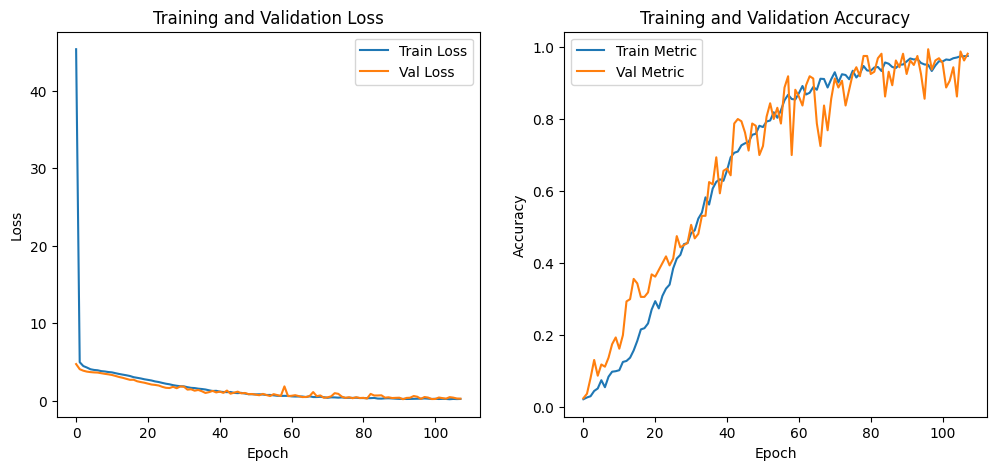

In [8]:
# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Metric")
plt.plot(val_accs, label="Val Metric")
plt.xlabel("Epoch")
plt.ylabel(
    "Accuracy"
    if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks]
    else "RMSE"
)
plt.legend()
plt.title(
    f"Training and Validation {'Accuracy' if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks] else 'RMSE'}"
)

plt.show()

In [ ]:
# Test Evaluation
# Load best checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
if "optimizer_state_dict" in checkpoint:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

epoch_loaded = checkpoint.get("epoch")
val_metric_loaded = checkpoint.get("val_metric")
val_loss_loaded = checkpoint.get("val_loss")
print(
    f"Loaded checkpoint from {MODEL_PATH} (epoch={epoch_loaded}, val_metric={val_metric_loaded}, val_loss={val_loss_loaded})"
)

test_results = evaluate_model(
    model,
    test_loader,
    device,
    TASK,
    criterion=criterion if TASK not in [Task.multi_tasks] else None,
    criterion_pose=criterion_pose if TASK == Task.multi_tasks else None,
    criterion_depth=criterion_depth if TASK == Task.multi_tasks else None,
    num_classes_p=num_classes_p if "num_classes_p" in locals() else 0,
    num_classes_r=num_classes_r if "num_classes_r" in locals() else 0,
    multi_label=multi_label,
    multi_tasks_regression_loss_weight=MULTI_TASKS_REGRESSION_LOSS_WEIGHT,
)

test_metric = test_results.get("accuracy", test_results.get("rmse", 0.0))
test_rmse = test_results.get("rmse", 0.0)
accuracy_p = test_results.get("accuracy_p", 0.0)
accuracy_r = test_results.get("accuracy_r", 0.0)

if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks]:
    print(f"Test Set Accuracy: {test_metric:.4f}")
    if TASK == Task.pose_multi:
        print(f"Test Set P Accuracy: {accuracy_p:.4f}")
        print(f"Test Set R Accuracy: {accuracy_r:.4f}")
    if TASK == Task.multi_tasks:
        print(f"Test Set RMSE: {test_rmse:.4f}")
        if multi_label:
            print(f"Test Set P Accuracy: {accuracy_p:.4f}")
            print(f"Test Set R Accuracy: {accuracy_r:.4f}")
else:
    print(f"Test Set RMSE: {test_metric:.4f}")

Loaded checkpoint from ../model/vgg19_bn_multi_tasks_augmented.pth (epoch=92, val_metric=0.9625, val_loss=0.20054453909397124)
Test Set Accuracy: 0.9575
Test Set RMSE: 0.1239
Test Set Accuracy: 0.9575
Test Set RMSE: 0.1239


In [10]:
results = {
    "model_name": MODEL_NAME,
    "metric_name": "accuracy"
    if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks]
    else "rmse",
    "metric_value": test_metric,
    "metadata": {
        "N_EPOCHS": N_EPOCHS + start_epoch if CONTINUE_TRAINING else N_EPOCHS,
        "EARLY_STOPPING_PATIENCE": EARLY_STOPPING_PATIENCE,
        "augmentation": AUGMENTATION,
        "learning_rate": LEARNING_RATE,
        "multi_label": multi_label,
        "multi_tasks_regression_loss_weight": MULTI_TASKS_REGRESSION_LOSS_WEIGHT,
    },
}

if TASK == Task.pose_multi or (TASK == Task.multi_tasks and multi_label):
    results["metadata"]["accuracy_p"] = accuracy_p
    results["metadata"]["accuracy_r"] = accuracy_r

if TASK == Task.multi_tasks:
    results["metadata"]["rmse"] = test_rmse

out_dir = f"../eval/{TASK}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

out_path = os.path.join(out_dir, f"{MODEL_NAME}.json")

if os.path.exists(out_path):
    try:
        with open(out_path, "r") as f:
            existing = json.load(f)
    except Exception:
        existing = None

    if isinstance(existing, list):
        existing.append(results)
        data_to_write = existing
    elif isinstance(existing, dict):
        data_to_write = [existing, results]
    else:
        data_to_write = [results]
else:
    data_to_write = [results]

with open(out_path, "w") as f:
    json.dump(data_to_write, f, indent=2)

print(f"Saved results to {out_path}")

Saved results to ../eval/multi_tasks/vgg19_bn_multi_tasks_augmented.json
